# Yield-gap (maize) analysis and plotting for Africa

A quick analysis of yield-gaps and N2O emissions for Africa.

YG data: [source](http://www.earthstat.org/yield-gaps-climate-bins-major-crops/)

This notebook produces the summary figure for the publication.

Panels:  
- Yield gap
- N2O emissions
- N2O emissions YG-closed 50%
- N2O emissions YG-closed 75%
- N2O emissions vs yield-gap
- Yield-scaled N2O emissions



In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [46]:
import numpy as np
import proplot as plot
import pandas as pd
import xarray as xr

In [5]:
ds = xr.open_dataset("yieldgap_maize_0083deg.nc")
ds

<xarray.Dataset>
Dimensions:  (lat: 1080, lon: 1080)
Coordinates:
  * lat      (lat) float32 -49.9583 -49.875 -49.7917 ... 39.7917 39.875 39.9583
  * lon      (lon) float32 -29.9583 -29.875 -29.7917 ... 59.7917 59.875 59.9583
Data variables:
    ygap     (lat, lon) float32 ...
    mask     (lat, lon) bool ...
    ygapm    (lat, lon) float32 ...

In [86]:
def yieldgap2emis(x, y0=5.704, a=-0.686, b=0.025, rate=None):
    if rate:
        return y0 - (y0*rate + a*x + b*x**2)  
    else:
        return y0 - (y0 + a*x + b*x**2)

In [87]:
def yieldgap2emisB(x, y0=5.704, a=-0.686, b=0.025, rate=None):
    if rate:
        return y0 + a*(x*rate) + b*(x*rate)**2
    else:
        return y0 + a*x + b*x**2

In [88]:
def yieldscaledemis(x, y0=0.313, a=2.797e-12, b=4.718):
    return y0+a*b**x

In [89]:
# these numbers are bullshit, replace with actual
ds["n2o"] = yieldgap2emis(ds.ygapm)
ds["n2o_50p"] = yieldgap2emisB(ds.ygapm, rate=0.50)
ds["n2o_75p"] = yieldgap2emisB(ds.ygapm, rate=0.75)
ds["ysemis"] = yieldscaledemis(ds.ygapm)

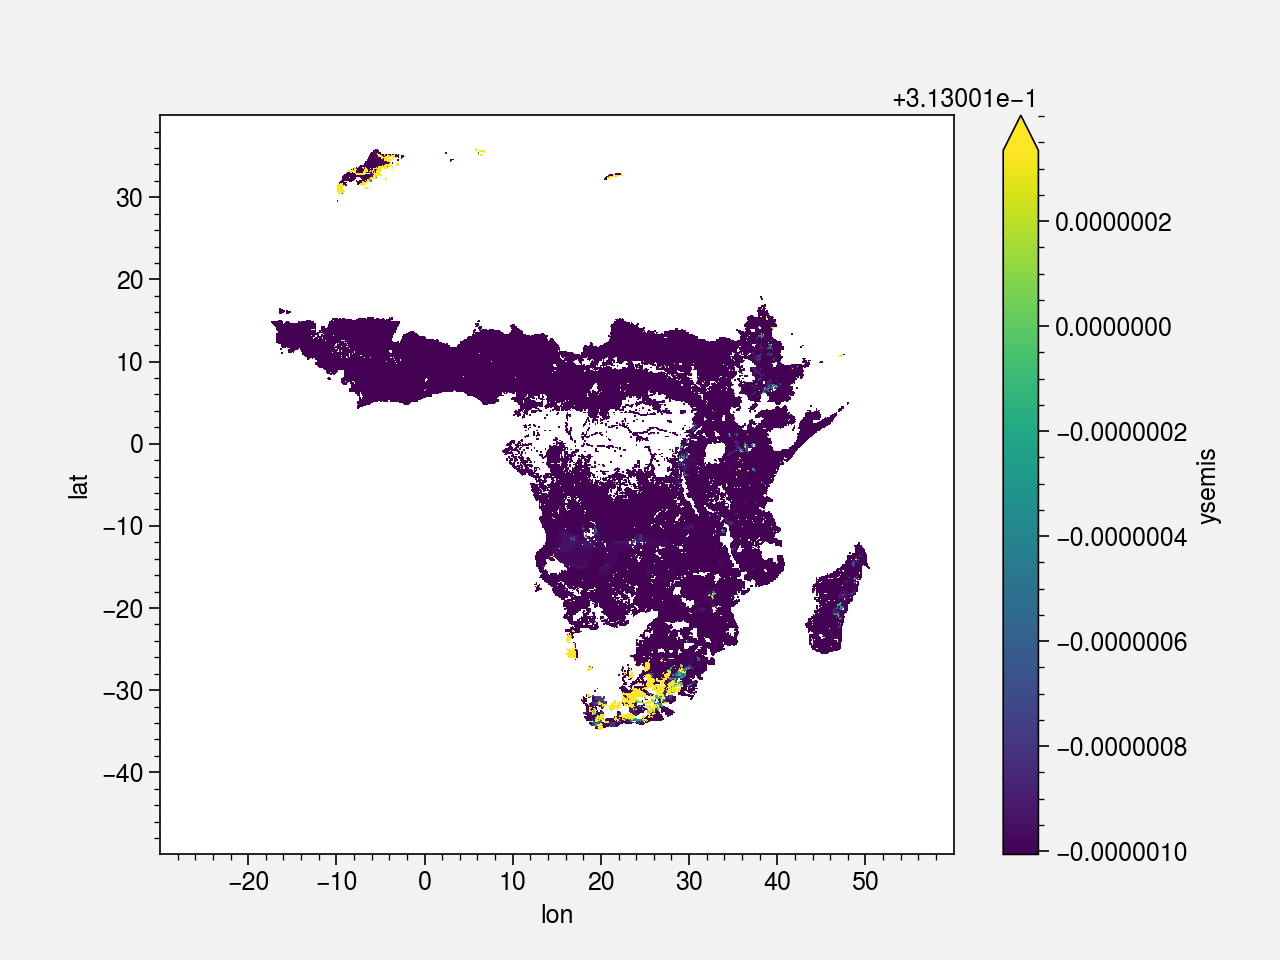

In [90]:
ds.ysemis.plot(robust=True)

In [68]:
def preprocess_edgar_nc(da, convert_n2o_units=True):
    if convert_n2o_units:
        if da.units == 'kg m-2 s-1':
            da = da * 3600 * 24 * 365 * 10000
            da.attrs['units'] = 'kg ha-1 yr-1'
        else:
            print('unexpected unit - no conversion')

    # also shift dataset from 0...360 longitude to -180...180
    da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180)).sortby('lon')
    # make sure we have clean 2 digit lons
    da = da.assign_coords(lon=da.lon.round(2))
    da['lon'].attrs['long_name'] = 'longitude [degrees_east]'
    return da

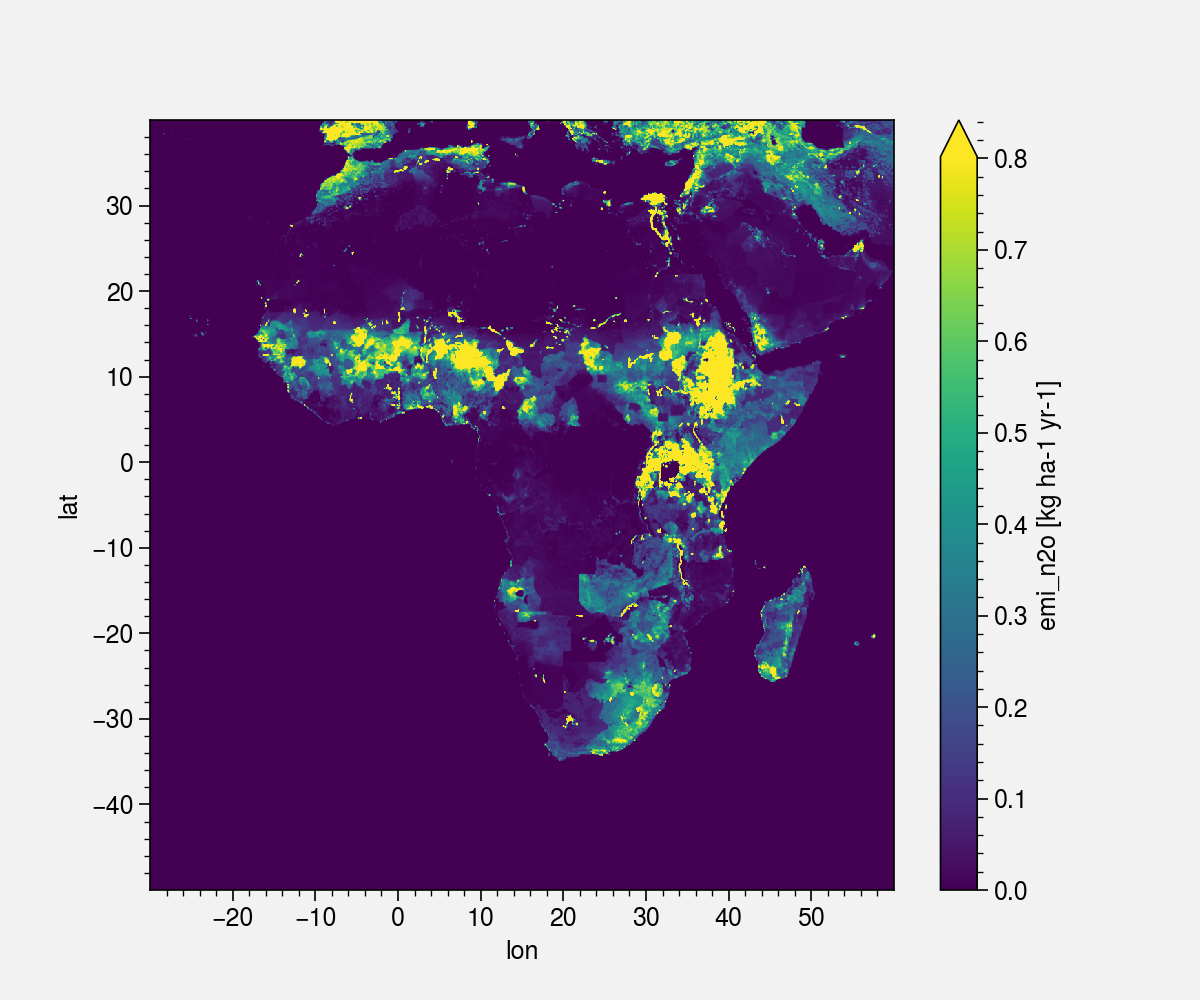

In [80]:
ds2 = xr.open_dataset("data/v50_N2O_2015_AGS.0.1x0.1.nc")
ds2 = preprocess_edgar_nc(ds2["emi_n2o"])
ds2 = ds2.sel(lat=slice(-50, 40), lon=slice(-30,60))

#interpolate into the higher resolution grid
ds2 = ds2.interp(lat=ds.lat, lon=ds.lon)
ds2.plot(figsize=(6,5), robust=True);

In [91]:
df = pd.read_csv('data/input data.csv')
df.columns = ['n2o', 'yieldscaled_n2o', 'yieldgap']
df

,n2o,yieldscaled_n2o,yieldgap
0,0.152,0.026207,12.563000
1,0.349,0.047808,11.063000
2,0.333,0.044400,10.863000
3,0.427,0.047444,9.363000
4,0.830,0.091209,9.263000
...,...,...,...
67,0.400,0.107954,14.657725
68,0.500,0.111537,13.880202
69,0.600,0.130246,13.756349
70,0.700,0.123313,12.686395


In [99]:
colors = 'sunset'
colors_ls = 'marine' #'Purples' #'RdPu'
#VMAX = 10
#LEVELS=[0, 0.5, 1, 2, 3, 5, 7.5, 10]
VMAX=5
LEVELS=[0, 0.25, 0.5, 0.75, 1, 2, 3, 4, 5]

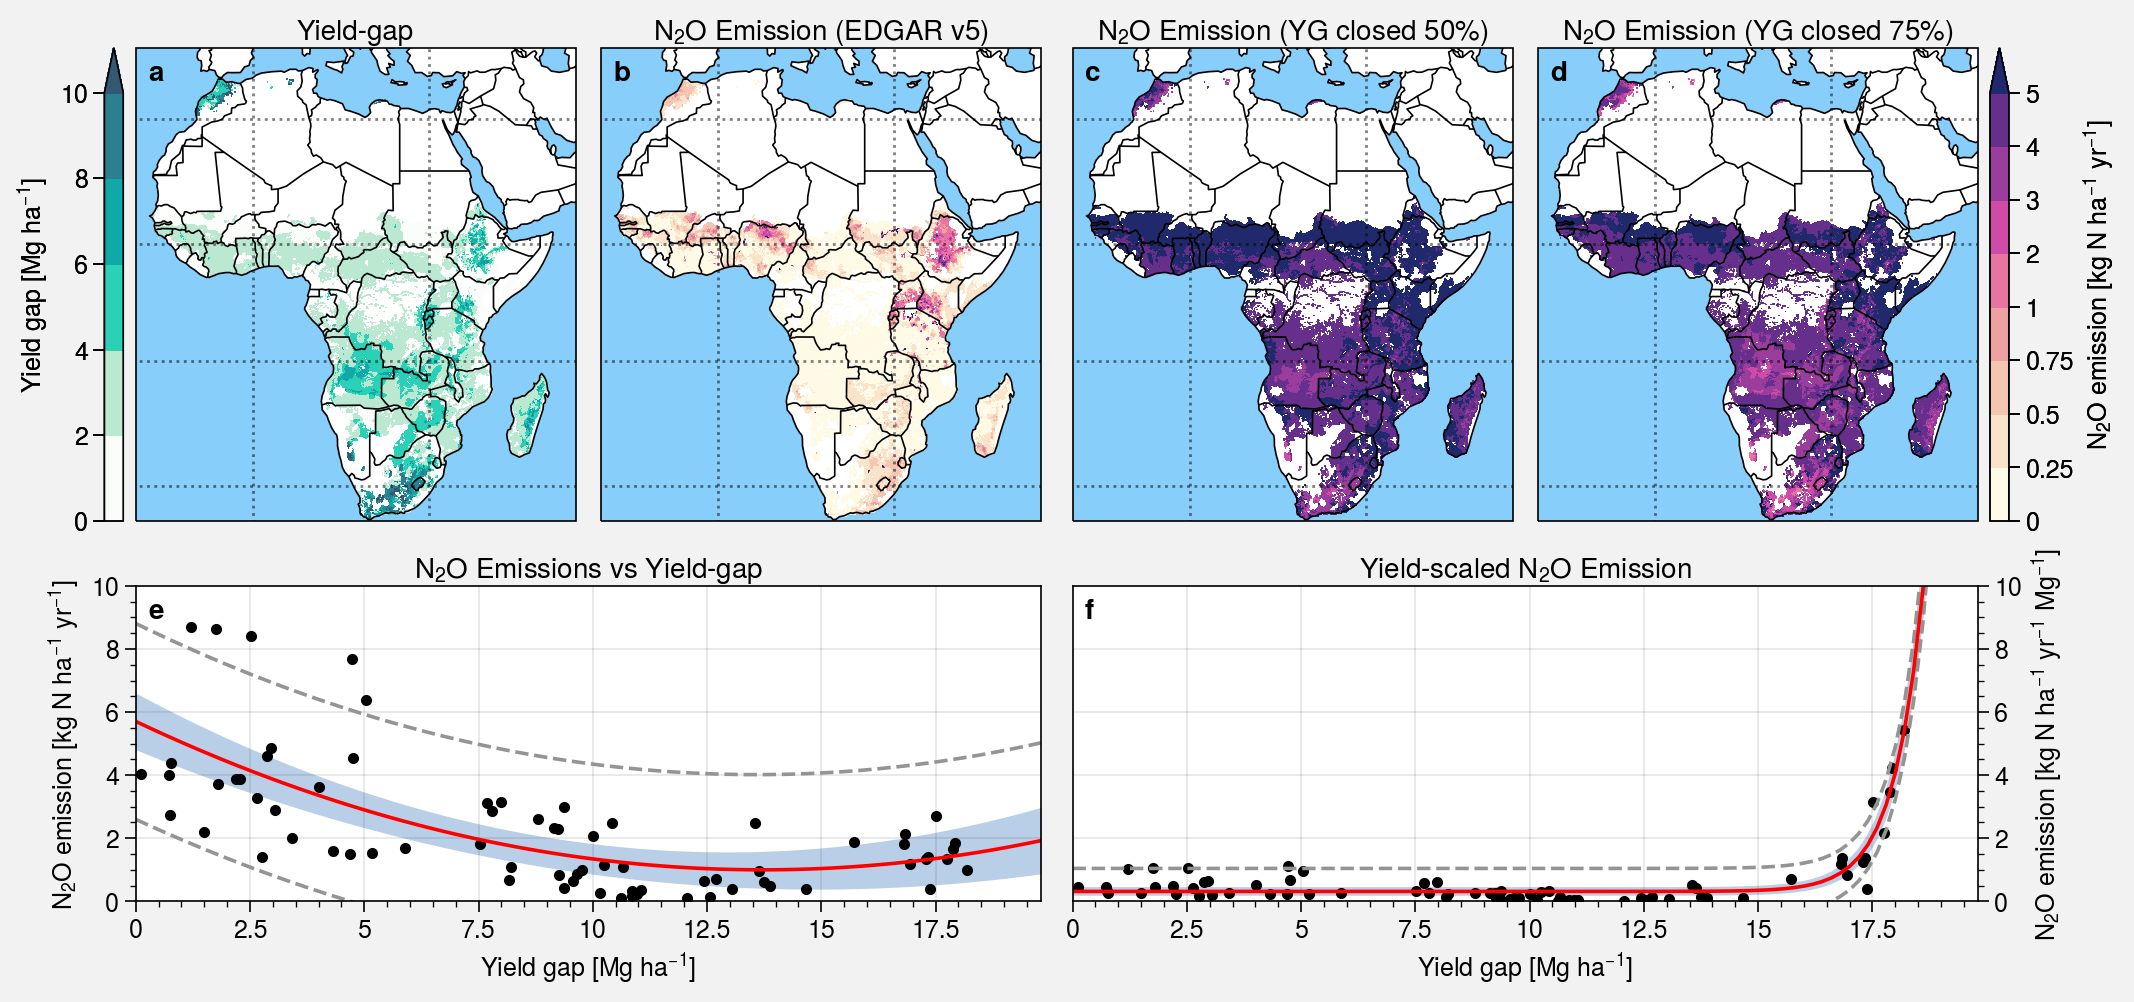

In [100]:
f, axs = plot.subplots([[1, 2, 3, 4], [5, 5, 6, 6]], 
                       hratios=(1.5, 1.),
                       axwidth=2.2,
                       share=0,
                       proj={k:'merc' for k in [1,2,3,4]}) #, share=3)


axs.format(abc=True, 
           abcloc='ul',
           abcborder=False)

# top row
for i, var in enumerate(['n2o', 'n2o_50p', 'n2o_75p']):
    m = axs[i+1].pcolormesh(
        #ds[var].where(ds[var] > -1), 
        ds2.where(ds[var] > -1) if var == 'n2o' else ds2.where(ds[var] > -1) + ds[var].where(ds[var] > -1),
        cmap=colors,
        colorbar='r' if i==2 else None, 
        colorbar_kw={'label': 'N$_2$O emission [kg N ha$^{-1}$ yr$^{-1}$]', 'width': '0.75em'} if i==2 else None, 
        vmin=0, vmax=VMAX, levels=LEVELS,
        extend='max',
        linewidth=0.7, #color='gray7'
    )


# livestock units
axs[0].pcolormesh(
    ds.ygapm.where(ds.ygapm>-1), 
    cmap=colors_ls,
    colorbar='l', 
    linewidth=0.7,
    cmap_kw={'right': 0.8},
    colorbar_kw={'label': 'Yield gap [Mg ha$^{-1}$]', 'width': '0.75em'}, 
    vmin=0, vmax=12, levels=[0, 2, 4, 6, 8, 10],
    extend='max',
)

# -----------------
# data plots

# formula for n2o emissions vs yield-gap
def compute_confidence_band1(x):
    """confidence band 1"""
    lw_95c = 4.855 -0.595*x + 0.02*x**2
    up_95c = 6.553 -0.777*x + 0.03*x**2
    
    lw_95p = 2.599 -0.666*x + 0.024*x**2
    up_95p = 8.809 -0.706*x + 0.026*x**2
    
    y = 5.704 -0.686*x + 0.025*x**2
    
    return (y, lw_95c, up_95c, lw_95p, up_95p)

# formula for yield-scaled emissions
def compute_confidence_band2(x):
    """confidence band 2"""
    lw_95c = 0.221 + 1.247e-12 * 4.91**x
    up_95c = 0.406 + 5.62e-12 * 4.559**x
    
    lw_95p = -0.415 + 3.266e-12 * 4.670**x
    up_95p = 1.042 + 2.404e-12 * 4.765**x

    y = 0.313 +2.797e-12 * 4.718**x
   
    return (y, lw_95c, up_95c, lw_95p, up_95p)

x = np.arange(0,20,0.2)
y, lw_95c, up_95c, lw_95p, up_95p = compute_confidence_band1(x)

p1 = axs[4].fill_between(x, lw_95c, up_95c, color="#b9cfe7", edgecolor="", 
                       label='95% confidence')

p2a = axs[4].plot(x, lw_95p, linestyle='dashed', c='gray', 
               label='95% pred. uncertainty')
p2b = axs[4].plot(x, up_95p, linestyle='dashed', c='gray')

p3 = axs[4].plot(x, y, c='red')

axs[4].scatter(df.yieldgap, df.n2o, c='black')


#leg = axs[4].legend(loc='ur', ncols=1, frame=False)



y, lw_95c, up_95c, lw_95p, up_95p = compute_confidence_band2(x)

p1 = axs[5].fill_between(x, lw_95c, up_95c, color="#b9cfe7", edgecolor="", 
                       label='95% confidence')

p2a = axs[5].plot(x, lw_95p, linestyle='dashed', c='gray', 
               label='95% pred. uncertainty')
p2b = axs[5].plot(x, up_95p, linestyle='dashed', c='gray')

p3 = axs[5].plot(x, y, c='red')

axs[5].scatter(df.yieldgap, df.yieldscaled_n2o, c='black')

labels = ["Yield-gap", 
          "N$_2$O Emission (EDGAR v5)", 
          "N$_2$O Emission (YG closed 50%)", 
          "N$_2$O Emission (YG closed 75%)",
          "N$_2$O Emissions vs Yield-gap",
          "Yield-scaled N$_2$O Emission"]

# maps
for i in range(4):
    axs[i].format(
        title=labels[i],
        lonlim=(-20, 55), latlim=(-35, 40),
        borders=True,
        coast=True,
        ocean=True,
        oceancolor='lightskyblue',
    )

# data panels
for i in range(4, 6):
    axs[i].format(
        title=labels[i],
        ylim=(0, 10),
        xlabel='Yield gap [Mg ha$^{-1}$]'
    )

axs[4].format(ylabel='N$_2$O emission [kg N ha$^{-1}$ yr$^{-1}$]')
axs[5].format(ylabel='N$_2$O emission [kg N ha$^{-1}$ yr$^{-1}$ Mg$^{-1}$]',
              ytickloc='right',
              yticklabelloc='right')
    

In [101]:
f.savefig("panelplot_yieldgap.png", dpi=400, facecolor='w')

## Yield-scaled emissions

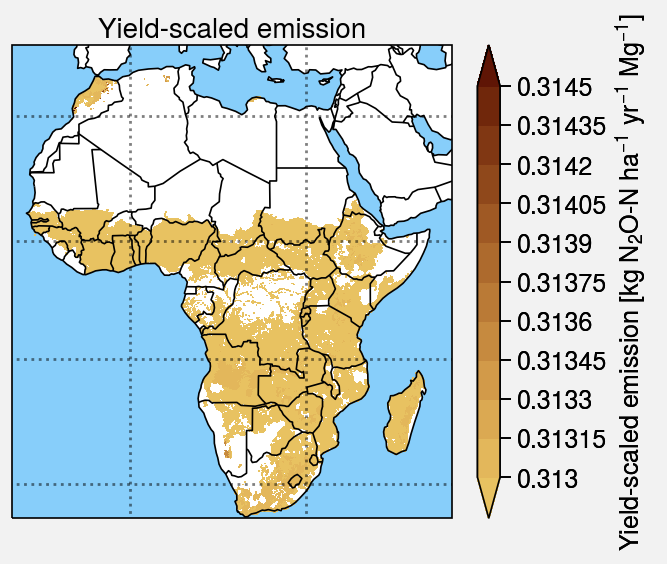

In [92]:
f, ax = plot.subplots(axwidth=2.2, proj='merc')
m= ax.pcolormesh(
       ds.ysemis.where(ds.ysemis >- 1), 
       cmap='stellar',
       cmap_kw={'left': 0.2, 'right': 0.8},
       #vmin=0.3, vmax=0.315, levels=[0.3, 0.3025, 0.305,  0.3075, 0.31, 0.315],
       extend='both',
       linewidth=0.7,
)
ax.format(
    title='Yield-scaled emission',
    lonlim=(-20, 55), latlim=(-35, 40),
    borders=True,
    coast=True,
    ocean=True,
    oceancolor='lightskyblue'
)
f.colorbar(m, loc='r', label='Yield-scaled emission [kg N$_2$O-N ha$^{-1}$ yr$^{-1}$ Mg$^{-1}$]', width='0.9em');    

Do not use plot - does not really make sense... 🤷

In [20]:
f.savefig("livestockunits.png", dpi=600, facecolor='w')

In [87]:
ds.ysemis.max()

<xarray.DataArray 'ysemis' ()>
array(0.31460002, dtype=float32)